In [1]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unyt import kW, minute, hr, day, MW
import sys

# osier imports
from osier import DispatchModel
from osier import CapacityExpansion
import osier.tech_library as lib

# pymoo imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.termination.robust import RobustTermination

# automatically set the solver
if "darwin" in sys.platform:
    solver = 'cplex_direct'
elif "linux" in sys.platform:
    solver = "cbc"
else:
    solver = "cbc"

print(f"Solver set: {solver}")

Solver set: cplex_direct


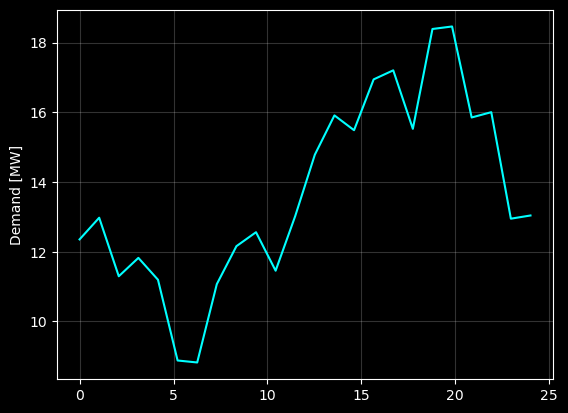

In [3]:
n_hours = 24  # hours per day
n_days = 1  # days to model
N = n_hours*n_days  # total number of time steps
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
hours = np.linspace(0,N,N)
total_demand = 328.16  # [MWh], sets the total demand [units of energy]

demand = (np.sin((hours*np.pi/n_hours*2+phase_shift))*-1+np.ones(N)*(base_shift+1))

np.random.seed(1234) # sets the seed for repeatability

noise = np.random.random(N)
demand += noise

demand = demand/demand.sum() * total_demand  # rescale

with plt.style.context("dark_background"):
    plt.plot(hours, demand, color='cyan')
    plt.ylabel('Demand [MW]')
    plt.grid(alpha=0.2)
    plt.show()

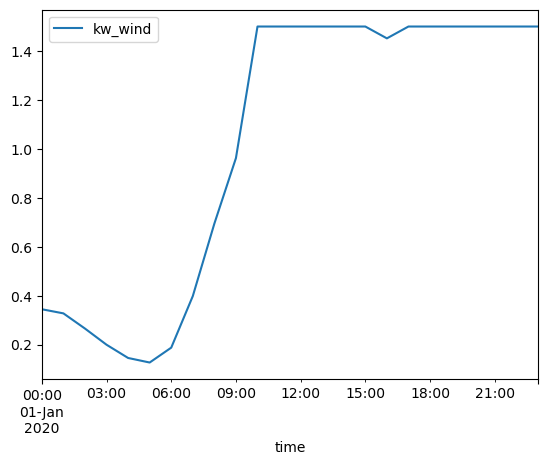

In [4]:
#importing wind data
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/nsrdb_data/windHistory_2020.csv"
wind_power_data = pd.read_csv(url, usecols=['time', 'kw_wind'], parse_dates=True,index_col='time')
wind_power = wind_power_data.loc['2020-01-01']#'2020-01-02']
#wind_power2 = wind_power_data.loc['2020-01-02']
wind_power.plot();plt.show()

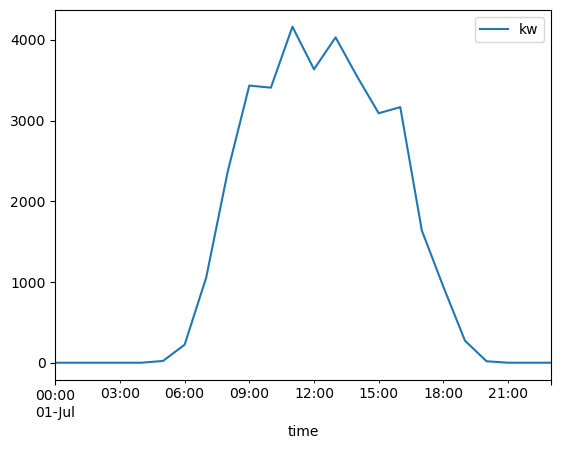

In [5]:
url = "https://raw.githubusercontent.com/samgdotson/2021-dotson-ms/refs/heads/master/data/solarfarm_data.csv"
solar_power = pd.read_csv(url, usecols=['time', 'kw'], parse_dates=True, index_col='time')

# choose a single day
solar_day = solar_power.loc['2016-07-01']
solar_day.plot();plt.show()

In [6]:
#getting the energy production values to run in the model

#solar power
solar_day_ener = solar_day['kw'].values
df_solar = pd.DataFrame(solar_day_ener, columns=['Energy'])
solar_ener = df_solar['Energy'].values

#wind power
df_wind = pd.DataFrame(wind_power,columns=['Energy'])
wind_ener = df_wind['Energy'].values

In [16]:
#creating energy mix

#based off osier documentation, we need to include geothermal and add the capacity for coal
#adding capacity of coal, based on research
from osier.tech_library import coal

#finally, create the necessary energy mix
UIUC_mix = [lib.natural_gas,lib.coal,lib.solar,lib.wind]
display(UIUC_mix)


[NaturalGas_Conv: 8375.1331 MW,
 Coal_Conv: 0.0 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

In [19]:
#now wanting to do a multi-objective run
#considered total cost, lets consider limitng CO2 emissions
from osier import annual_emission, total_cost
problem2 = CapacityExpansion(technology_list = UIUC_mix,
                            demand=demand*MW,
                            solar=solar_ener,
                            wind=wind_ener,
                            upper_bound= 1 / lib.solar.capacity_credit,
                            objectives = [total_cost,annual_emission],
                            solver=solver)  # the objectives must be passed as a LIST of functions!

In [20]:
algorithm = NSGA2(pop_size=20)
termination = RobustTermination(MultiObjectiveSpaceTermination(tol=0.5, n_skip=5), period=20)
import time
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
end = time.perf_counter()
print(f"The simulation took {(end-start)/60:.3f} minutes.")

ValueError: Constraint 'oversupply[1]' created with an invalid non-finite upper bound (nan).

In [54]:
#displaying multi-objective results
display(res.F),display(res.X)

array([[3.74124916e+00, 8.76424387e-06],
       [9.85679420e-01, 1.61806909e-04],
       [3.11532541e+00, 9.99723784e-06],
       [1.22488876e+00, 1.27758676e-04],
       [3.71779426e+00, 8.89000885e-06],
       [2.29790987e+00, 3.30487164e-05],
       [1.08221148e+00, 1.42944315e-04],
       [1.63338180e+00, 8.76107362e-05],
       [1.46973019e+00, 1.05896262e-04],
       [1.89427443e+00, 6.39376026e-05],
       [2.10647798e+00, 4.13318400e-05],
       [2.69510543e+00, 1.70921985e-05],
       [1.52452651e+00, 9.68048481e-05],
       [2.04083152e+00, 4.71151930e-05],
       [1.04746697e+00, 1.50222296e-04],
       [2.55545814e+00, 2.57617683e-05],
       [2.52297868e+00, 3.07126691e-05],
       [2.85720721e+00, 1.49954449e-05],
       [1.87091147e+00, 6.60912462e-05],
       [3.02966187e+00, 1.45621279e-05]])

array([[2.09170129e-01, 3.05245864e-04, 4.77298601e-01, 2.18501429e+00],
       [9.51547850e-01, 2.66661937e-02, 4.53326443e-05, 4.56878380e-02],
       [1.44442691e-01, 3.12532510e-04, 4.95153295e-01, 1.79513364e+00],
       [9.91645660e-01, 1.10105947e-03, 4.59473796e-01, 8.79457701e-03],
       [2.10232598e-01, 3.05245864e-04, 4.39451994e-01, 2.18501429e+00],
       [5.48595735e-01, 4.29543958e-04, 4.79248991e-01, 1.00067226e+00],
       [9.44119079e-01, 4.60731345e-04, 1.04604218e-01, 9.65647223e-02],
       [8.42703534e-01, 2.45175189e-03, 4.64638391e-01, 3.73775596e-01],
       [8.20609610e-01, 1.09419509e-04, 9.39181143e-02, 4.40210031e-01],
       [7.51496795e-01, 3.61622865e-06, 4.76786070e-01, 6.03851359e-01],
       [5.48595735e-01, 3.84079405e-04, 4.50635577e-01, 8.83849612e-01],
       [2.95961152e-01, 1.79461038e-04, 6.93546257e-01, 1.33185775e+00],
       [9.37728716e-01, 2.45175189e-03, 7.92522276e-01, 9.87324224e-02],
       [5.94873345e-01, 4.61228285e-04, 4.41338276e

(None, None)

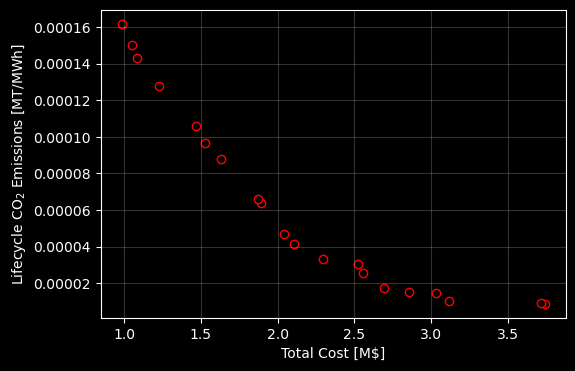

In [55]:
with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1,figsize=(6,4))

    ax.scatter(res.F[:,0], res.F[:,1], edgecolors='red', facecolors='k')
    ax.set_ylabel(r"Lifecycle CO$_2$ Emissions [MT/MWh]")
    ax.set_xlabel(r"Total Cost [M\$]")
    ax.grid(alpha=0.2)

    plt.show()